In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import optuna
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # normalize the dataset to range [-1, 1]
    transforms.RandomRotation(10),  # rotate the image randomly by 10 degrees
    transforms.RandomHorizontalFlip()  # flip the image horizontally with a 50% probability
])

# Download and load the training data
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create indices for training and validation splits
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)

# Define split size
split = int(0.2 * num_train)  # 20% for validation
train_idx, val_idx = indices[split:], indices[:split]

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create data loaders with samplers
trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)

# Download and load the test data
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [3]:
# Let's check if our data is loaded correctly
images, labels = next(iter(trainloader))

print(images.shape)
print(len(trainloader))
print(labels.shape)
print(len(testloader))

# Check each sample in the dataset
missing_samples = any(img is None or lbl is None for img, lbl in trainset)

if missing_samples:
    print("Missing data detected in individual samples.")
else:
    print("No missing data found in individual samples.")

torch.Size([64, 1, 28, 28])
750
torch.Size([64])
157
No missing data found in individual samples.


In [4]:
unique_labels, counts = np.unique(trainset.targets, return_counts=True)
print(f"Unique labels: {unique_labels}")
print(f"Counts: {counts}")

print("Number of samples per digit:")
for label, count in zip(unique_labels, counts):
    print(f"Digit {label}: {count}")

# Check if the data distribution is balanced
total_samples = len(trainset.targets)
min_samples = min(counts)
max_samples = max(counts)
balance_ratio = min_samples / max_samples

print(f"\nTotal samples: {total_samples}")
print(f"Balance ratio (min/max): {balance_ratio}")

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Number of samples per digit:
Digit 0: 6000
Digit 1: 6000
Digit 2: 6000
Digit 3: 6000
Digit 4: 6000
Digit 5: 6000
Digit 6: 6000
Digit 7: 6000
Digit 8: 6000
Digit 9: 6000

Total samples: 60000
Balance ratio (min/max): 1.0


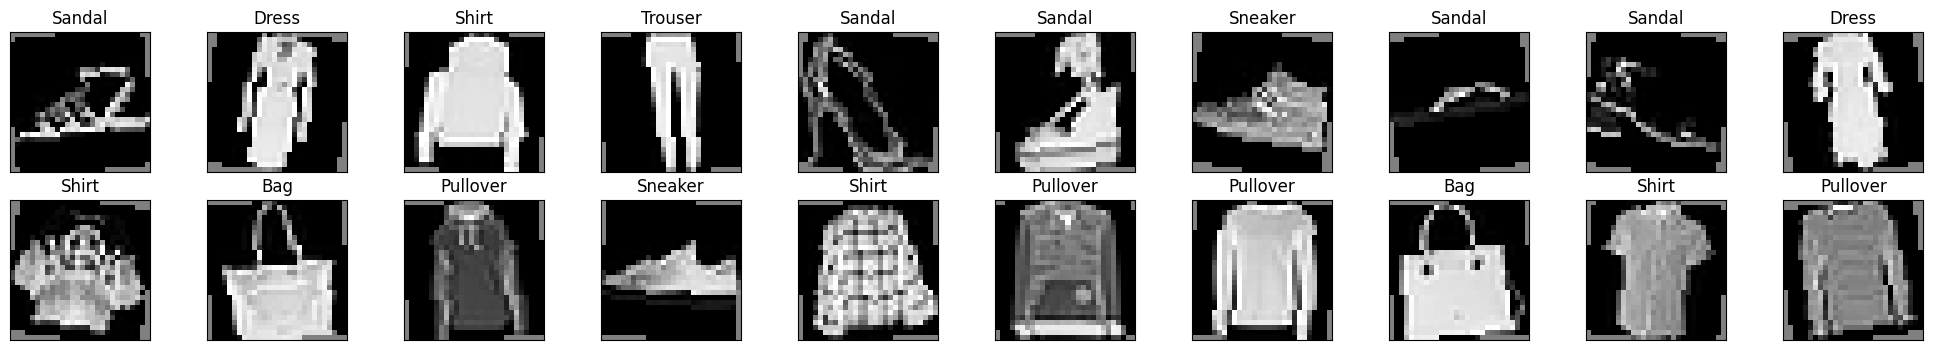

In [5]:
# Let's plot all the unique labels from the dataset
# Define the text labels
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(text_labels[labels[idx].item()])
plt.show()

In [6]:
class SimpleCNNImage(nn.Module):
    def __init__(self, dropout=0.45, kernel_size=3, num_classes=10):
        super(SimpleCNNImage, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization added
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization added
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn3 = nn.BatchNorm1d(512)  # Batch normalization added
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)  # Batch normalization added
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Output Layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout1(self.relu3(self.bn3(self.fc1(x))))
        x = self.dropout2(self.relu4(self.bn4(self.fc2(x))))
        x1 = x
        x = self.fc3(x)
        return x1, x

In [7]:
model_path = "./model/best_model_state.pth"
best_model = SimpleCNNImage(dropout=0.45)
criterion = nn.CrossEntropyLoss() 

In [8]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            optimizer.zero_grad()
            _, outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                _, outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
                
        valid_losses.append(running_valid_loss / len(valid_loader))
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%")
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    dropout = trial.suggest_float('dropout', 0.3, 0.6)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 20)

    # Initialize the model, criterion, and optimizer with suggested parameters
    model = SimpleCNNImage(dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, criterion, optimizer, trainloader, valloader, num_epochs
    )

    # Return the best validation accuracy (maximize)
    return max(valid_accuracies)

[I 2024-11-07 14:14:20,264] A new study created in memory with name: no-name-af6e24f9-ae0c-4d31-b071-e3ba48093d7c
Epoch 1/16 - Validation: 100%|██████████| 188/188 [00:03<00:00, 49.45it/s]


Epoch 1/16, Train Loss: 0.5155, Valid Loss: 0.3470, Train Accuracy: 81.91%, Valid Accuracy: 87.26%


Epoch 2/16 - Validation: 100%|██████████| 188/188 [00:03<00:00, 48.55it/s]


Epoch 2/16, Train Loss: 0.3760, Valid Loss: 0.3049, Train Accuracy: 86.60%, Valid Accuracy: 88.53%


Epoch 3/16 - Validation: 100%|██████████| 188/188 [00:03<00:00, 49.89it/s]


Epoch 3/16, Train Loss: 0.3400, Valid Loss: 0.2957, Train Accuracy: 87.80%, Valid Accuracy: 88.89%


Epoch 4/16 - Validation: 100%|██████████| 188/188 [00:03<00:00, 50.22it/s]


Epoch 4/16, Train Loss: 0.3137, Valid Loss: 0.2723, Train Accuracy: 88.76%, Valid Accuracy: 90.02%


Epoch 5/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.48it/s]


Epoch 5/16, Train Loss: 0.2980, Valid Loss: 0.2574, Train Accuracy: 89.33%, Valid Accuracy: 90.29%


Epoch 6/16 - Validation: 100%|██████████| 188/188 [00:03<00:00, 48.15it/s]


Epoch 6/16, Train Loss: 0.2834, Valid Loss: 0.2543, Train Accuracy: 89.82%, Valid Accuracy: 90.67%


Epoch 7/16 - Validation: 100%|██████████| 188/188 [00:03<00:00, 47.08it/s]


Epoch 7/16, Train Loss: 0.2735, Valid Loss: 0.2539, Train Accuracy: 90.21%, Valid Accuracy: 90.83%


Epoch 8/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 43.87it/s]


Epoch 8/16, Train Loss: 0.2620, Valid Loss: 0.2456, Train Accuracy: 90.64%, Valid Accuracy: 90.86%


Epoch 9/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.00it/s]


Epoch 9/16, Train Loss: 0.2596, Valid Loss: 0.2424, Train Accuracy: 90.78%, Valid Accuracy: 91.57%


Epoch 10/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.69it/s]


Epoch 10/16, Train Loss: 0.2472, Valid Loss: 0.2388, Train Accuracy: 91.12%, Valid Accuracy: 91.41%


Epoch 11/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.64it/s]


Epoch 11/16, Train Loss: 0.2420, Valid Loss: 0.2471, Train Accuracy: 91.35%, Valid Accuracy: 90.98%


Epoch 12/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.14it/s]


Epoch 12/16, Train Loss: 0.2349, Valid Loss: 0.2399, Train Accuracy: 91.53%, Valid Accuracy: 91.35%


Epoch 13/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.40it/s]


Epoch 13/16, Train Loss: 0.2304, Valid Loss: 0.2218, Train Accuracy: 91.68%, Valid Accuracy: 91.75%


Epoch 14/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 43.78it/s]


Epoch 14/16, Train Loss: 0.2227, Valid Loss: 0.2231, Train Accuracy: 92.00%, Valid Accuracy: 91.92%


Epoch 15/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.42it/s]


Epoch 15/16, Train Loss: 0.2193, Valid Loss: 0.2273, Train Accuracy: 92.08%, Valid Accuracy: 91.76%


Epoch 16/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.20it/s]


Epoch 16/16, Train Loss: 0.2151, Valid Loss: 0.2381, Train Accuracy: 92.21%, Valid Accuracy: 91.46%


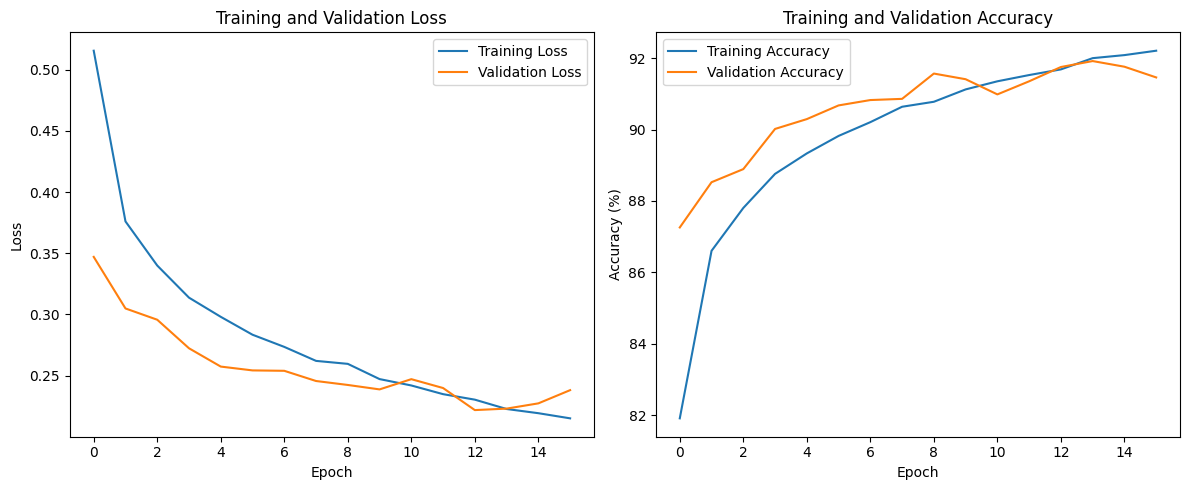

[I 2024-11-07 14:26:42,937] Trial 0 finished with value: 91.91666666666667 and parameters: {'dropout': 0.48784138976712044, 'learning_rate': 0.0031112998678175653, 'num_epochs': 16}. Best is trial 0 with value: 91.91666666666667.
Epoch 1/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.85it/s]


Epoch 1/15, Train Loss: 0.6784, Valid Loss: 0.4113, Train Accuracy: 80.87%, Valid Accuracy: 86.10%


Epoch 2/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.64it/s]


Epoch 2/15, Train Loss: 0.4042, Valid Loss: 0.3430, Train Accuracy: 86.72%, Valid Accuracy: 87.92%


Epoch 3/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.76it/s]


Epoch 3/15, Train Loss: 0.3390, Valid Loss: 0.3124, Train Accuracy: 88.34%, Valid Accuracy: 88.69%


Epoch 4/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.84it/s]


Epoch 4/15, Train Loss: 0.3107, Valid Loss: 0.2943, Train Accuracy: 89.03%, Valid Accuracy: 89.17%


Epoch 5/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.89it/s]


Epoch 5/15, Train Loss: 0.2923, Valid Loss: 0.2685, Train Accuracy: 89.62%, Valid Accuracy: 90.31%


Epoch 6/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.17it/s]


Epoch 6/15, Train Loss: 0.2771, Valid Loss: 0.2568, Train Accuracy: 90.19%, Valid Accuracy: 90.57%


Epoch 7/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.22it/s]


Epoch 7/15, Train Loss: 0.2604, Valid Loss: 0.2528, Train Accuracy: 90.71%, Valid Accuracy: 90.82%


Epoch 8/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.62it/s]


Epoch 8/15, Train Loss: 0.2515, Valid Loss: 0.2520, Train Accuracy: 91.05%, Valid Accuracy: 90.80%


Epoch 9/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 42.68it/s]


Epoch 9/15, Train Loss: 0.2440, Valid Loss: 0.2433, Train Accuracy: 91.28%, Valid Accuracy: 90.90%


Epoch 10/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.50it/s]


Epoch 10/15, Train Loss: 0.2368, Valid Loss: 0.2476, Train Accuracy: 91.56%, Valid Accuracy: 90.86%


Epoch 11/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.22it/s]


Epoch 11/15, Train Loss: 0.2252, Valid Loss: 0.2444, Train Accuracy: 91.97%, Valid Accuracy: 90.95%


Epoch 12/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.77it/s]


Epoch 12/15, Train Loss: 0.2224, Valid Loss: 0.2382, Train Accuracy: 91.95%, Valid Accuracy: 91.30%


Epoch 13/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.18it/s]


Epoch 13/15, Train Loss: 0.2159, Valid Loss: 0.2418, Train Accuracy: 92.23%, Valid Accuracy: 91.17%


Epoch 14/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.68it/s]


Epoch 14/15, Train Loss: 0.2109, Valid Loss: 0.2374, Train Accuracy: 92.57%, Valid Accuracy: 91.45%


Epoch 15/15 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.74it/s]


Epoch 15/15, Train Loss: 0.2065, Valid Loss: 0.2283, Train Accuracy: 92.52%, Valid Accuracy: 91.59%


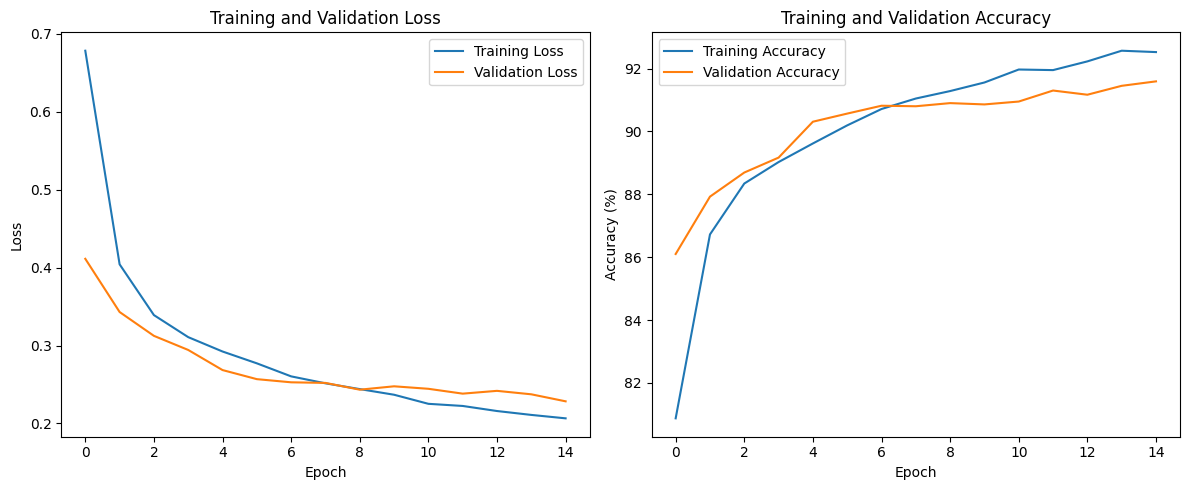

[I 2024-11-07 14:37:11,495] Trial 1 finished with value: 91.59166666666667 and parameters: {'dropout': 0.31676562312436024, 'learning_rate': 0.00010434894813379428, 'num_epochs': 15}. Best is trial 0 with value: 91.91666666666667.
Epoch 1/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.34it/s]


Epoch 1/9, Train Loss: 0.4803, Valid Loss: 0.3520, Train Accuracy: 83.46%, Valid Accuracy: 86.82%


Epoch 2/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.73it/s]


Epoch 2/9, Train Loss: 0.3345, Valid Loss: 0.2941, Train Accuracy: 88.09%, Valid Accuracy: 89.20%


Epoch 3/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.39it/s]


Epoch 3/9, Train Loss: 0.2987, Valid Loss: 0.2802, Train Accuracy: 89.27%, Valid Accuracy: 89.89%


Epoch 4/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.49it/s]


Epoch 4/9, Train Loss: 0.2790, Valid Loss: 0.2568, Train Accuracy: 89.85%, Valid Accuracy: 90.69%


Epoch 5/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.59it/s]


Epoch 5/9, Train Loss: 0.2603, Valid Loss: 0.2556, Train Accuracy: 90.53%, Valid Accuracy: 90.79%


Epoch 6/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.48it/s]


Epoch 6/9, Train Loss: 0.2475, Valid Loss: 0.2639, Train Accuracy: 91.05%, Valid Accuracy: 90.47%


Epoch 7/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.64it/s]


Epoch 7/9, Train Loss: 0.2388, Valid Loss: 0.2411, Train Accuracy: 91.24%, Valid Accuracy: 91.17%


Epoch 8/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.57it/s]


Epoch 8/9, Train Loss: 0.2312, Valid Loss: 0.2364, Train Accuracy: 91.62%, Valid Accuracy: 91.38%


Epoch 9/9 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.73it/s]


Epoch 9/9, Train Loss: 0.2191, Valid Loss: 0.2426, Train Accuracy: 92.04%, Valid Accuracy: 91.17%


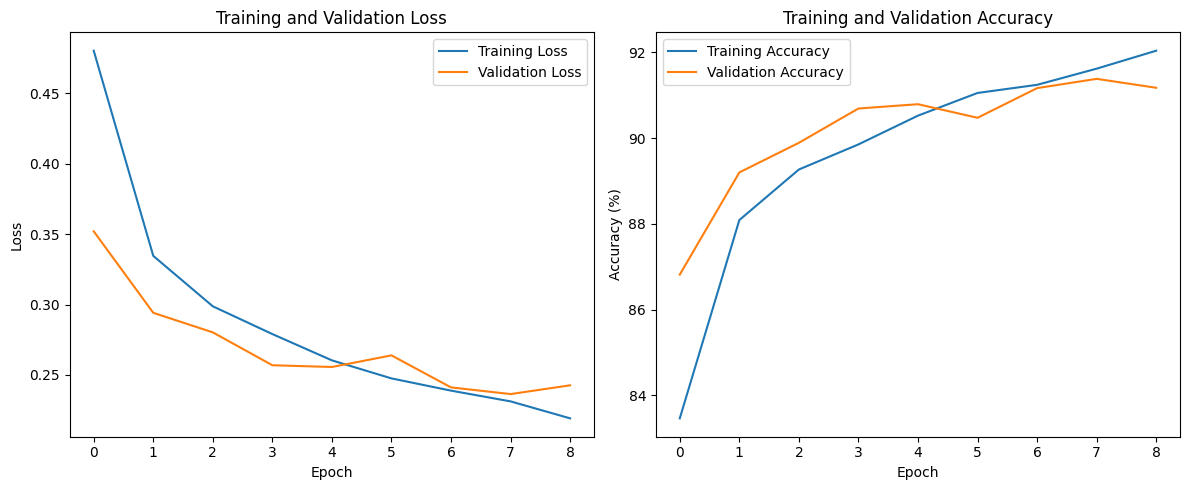

[I 2024-11-07 14:43:23,377] Trial 2 finished with value: 91.38333333333334 and parameters: {'dropout': 0.32370930768627393, 'learning_rate': 0.0009022163421449733, 'num_epochs': 9}. Best is trial 0 with value: 91.91666666666667.


Best parameters found:
{'dropout': 0.48784138976712044, 'learning_rate': 0.0031112998678175653, 'num_epochs': 16}


Epoch 1/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.99it/s]


Epoch 1/16, Train Loss: 0.5089, Valid Loss: 0.3422, Train Accuracy: 82.02%, Valid Accuracy: 87.03%


Epoch 2/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.87it/s]


Epoch 2/16, Train Loss: 0.3758, Valid Loss: 0.3095, Train Accuracy: 86.39%, Valid Accuracy: 88.83%


Epoch 3/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.08it/s]


Epoch 3/16, Train Loss: 0.3336, Valid Loss: 0.2850, Train Accuracy: 88.15%, Valid Accuracy: 89.83%


Epoch 4/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.85it/s]


Epoch 4/16, Train Loss: 0.3155, Valid Loss: 0.2875, Train Accuracy: 88.67%, Valid Accuracy: 89.42%


Epoch 5/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.62it/s]


Epoch 5/16, Train Loss: 0.2927, Valid Loss: 0.2634, Train Accuracy: 89.50%, Valid Accuracy: 90.11%


Epoch 6/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.60it/s]


Epoch 6/16, Train Loss: 0.2787, Valid Loss: 0.2549, Train Accuracy: 90.00%, Valid Accuracy: 90.67%


Epoch 7/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.11it/s]


Epoch 7/16, Train Loss: 0.2726, Valid Loss: 0.2675, Train Accuracy: 90.15%, Valid Accuracy: 90.03%


Epoch 8/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.08it/s]


Epoch 8/16, Train Loss: 0.2619, Valid Loss: 0.2423, Train Accuracy: 90.57%, Valid Accuracy: 91.16%


Epoch 9/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.19it/s]


Epoch 9/16, Train Loss: 0.2575, Valid Loss: 0.2384, Train Accuracy: 90.78%, Valid Accuracy: 91.38%


Epoch 10/16 - Validation: 100%|██████████| 188/188 [00:03<00:00, 47.11it/s]


Epoch 10/16, Train Loss: 0.2440, Valid Loss: 0.2392, Train Accuracy: 91.33%, Valid Accuracy: 91.51%


Epoch 11/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 45.43it/s]


Epoch 11/16, Train Loss: 0.2426, Valid Loss: 0.2497, Train Accuracy: 91.44%, Valid Accuracy: 90.86%


Epoch 12/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 41.79it/s]


Epoch 12/16, Train Loss: 0.2352, Valid Loss: 0.2371, Train Accuracy: 91.60%, Valid Accuracy: 91.17%


Epoch 13/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.20it/s]


Epoch 13/16, Train Loss: 0.2278, Valid Loss: 0.2263, Train Accuracy: 91.74%, Valid Accuracy: 91.92%


Epoch 14/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.44it/s]


Epoch 14/16, Train Loss: 0.2198, Valid Loss: 0.2286, Train Accuracy: 91.91%, Valid Accuracy: 91.73%


Epoch 15/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 46.35it/s]


Epoch 15/16, Train Loss: 0.2185, Valid Loss: 0.2256, Train Accuracy: 92.12%, Valid Accuracy: 91.54%


Epoch 16/16 - Validation: 100%|██████████| 188/188 [00:04<00:00, 44.53it/s]


Epoch 16/16, Train Loss: 0.2154, Valid Loss: 0.2218, Train Accuracy: 92.23%, Valid Accuracy: 91.98%


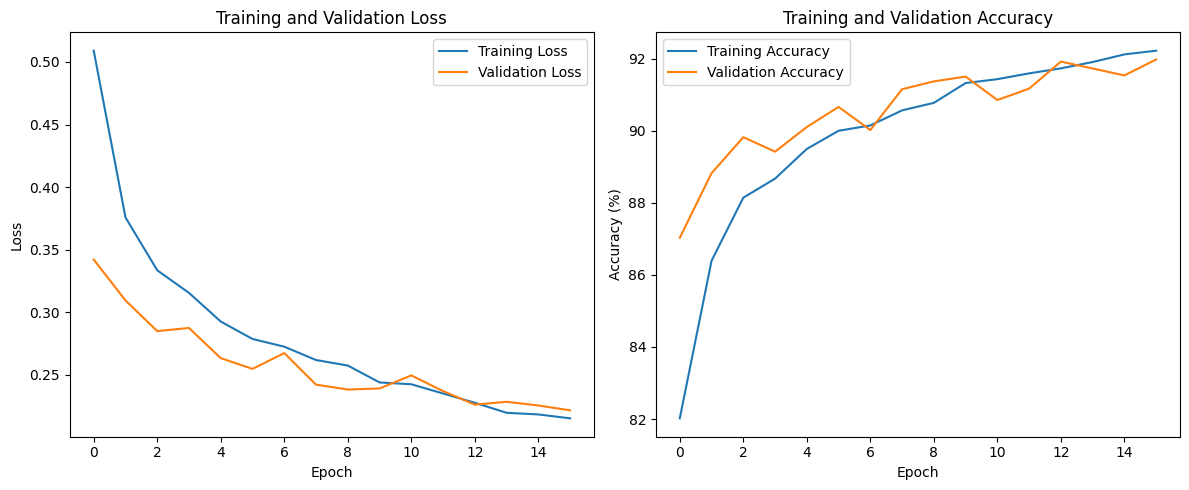

Model state dict saved to ./best_model_state.pth


In [ ]:
try:
    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()
except:
    # Create a study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=3)

    # Print best parameters
    print("Best parameters found:")
    print(study.best_params)

    # Evaluate on the testing set with the best model
    best_params = study.best_params
    best_model = SimpleCNNImage(dropout=best_params['dropout'])
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        best_model, criterion, optimizer, trainloader, valloader, best_params['num_epochs']
    )

    # Save the model state dict
    model_path = "./model/best_model_state.pth"
    torch.save(best_model.state_dict(), model_path)
    print(f"Model state dict saved to {model_path}")

In [11]:
# Plot the confusion matrix, f1 score, and classification report

def evaluate_model(model, loader):

    if loader == valloader:
        print("Evaluating on the validation set")
        flag = "val"
    elif loader == testloader:
        print("Evaluating on the test set")
        flag = "test"
        test_loss = 0
        correct_test = 0
        total_test = 0

    best_model.eval()
    y_true = []
    y_pred = []
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            _, outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

            # Find misclassified images
            misclassified_mask = predicted != labels
            misclassified_images.extend(images[misclassified_mask])
            true_labels.extend(labels[misclassified_mask])
            predicted_labels.extend(predicted[misclassified_mask])

            if flag == "test":
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

    if flag == "test":
        test_accuracy = 100 * correct_test / total_test
        print(f"Test Loss: {test_loss / len(testloader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return misclassified_images, true_labels, predicted_labels, y_true, y_pred

# Evaluate the model on the validation set
misclassified_images_val, true_labels_val, predicted_labels_val, y_true_val, y_pred_val = evaluate_model(best_model, valloader)

# Evaluate the model on the test set
misclassified_images_test, true_labels_test, predicted_labels_test, y_true_test, y_pred_test = evaluate_model(best_model, testloader)

Evaluating on the validation set


Testing: 100%|██████████| 188/188 [00:04<00:00, 42.07it/s]


Evaluating on the test set


Testing: 100%|██████████| 157/157 [00:03<00:00, 43.17it/s]

Test Loss: 0.2226, Test Accuracy: 92.10%


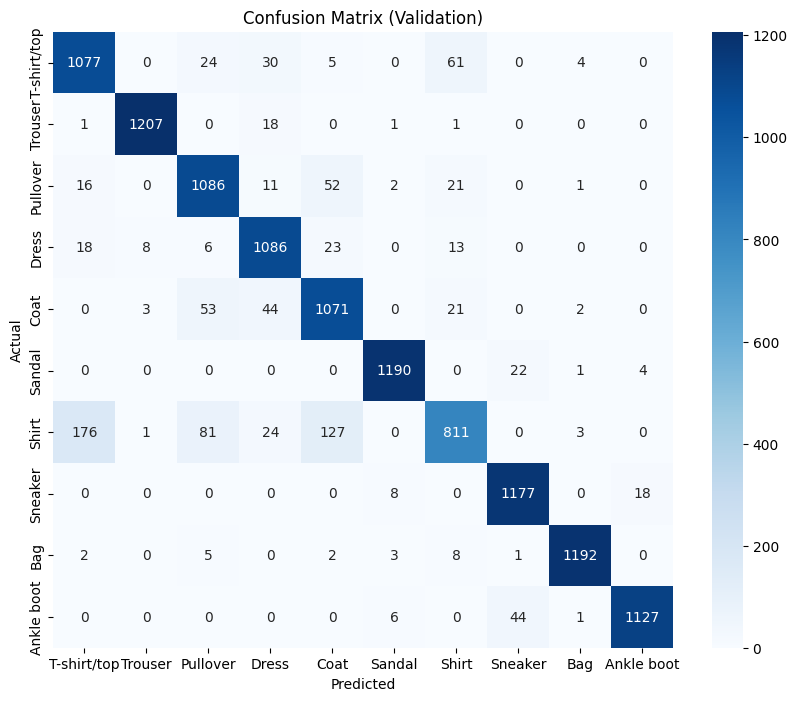

F1 Score: 0.9172 (Validation)
Classification Report: (Validation)
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.90      0.86      1201
     Trouser       0.99      0.98      0.99      1228
    Pullover       0.87      0.91      0.89      1189
       Dress       0.90      0.94      0.92      1154
        Coat       0.84      0.90      0.87      1194
      Sandal       0.98      0.98      0.98      1217
       Shirt       0.87      0.66      0.75      1223
     Sneaker       0.95      0.98      0.96      1203
         Bag       0.99      0.98      0.99      1213
  Ankle boot       0.98      0.96      0.97      1178

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000

Accuracy: 0.9187 (Validation)


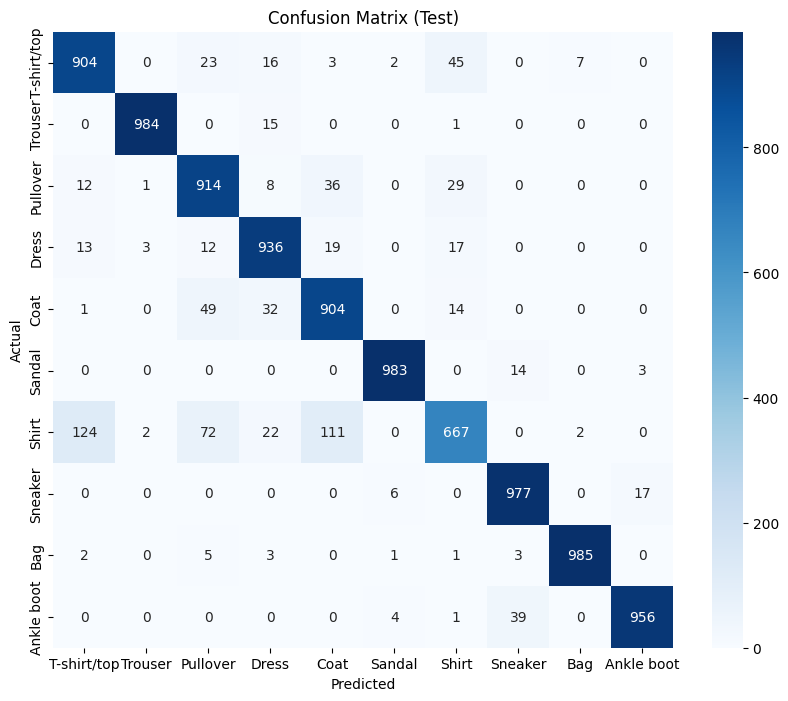

F1 Score: 0.9196 (Test)
Classification Report: (Test)
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.90      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.91      0.88      1000
       Dress       0.91      0.94      0.92      1000
        Coat       0.84      0.90      0.87      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.86      0.67      0.75      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy: 0.9210 (Test)


In [12]:
# Plot confusion matrix, f1 score, and classification report
def plot_results(y_true, y_pred, name):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=text_labels, yticklabels=text_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix' + f" ({name})")
    plt.show()

    # F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}" + f" ({name})")

    # Classification report
    report = classification_report(y_true, y_pred, target_names=text_labels)
    print("Classification Report:" + f" ({name})")
    print(report)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}" + f" ({name})")

# Plot the results for the validation set
plot_results(y_true_val, y_pred_val, "Validation")

# Plot the results for the test set
plot_results(y_true_test, y_pred_test, "Test")

Misclassified images (Validation)


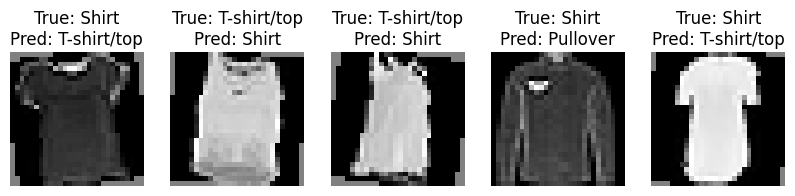

Misclassified images (Test)


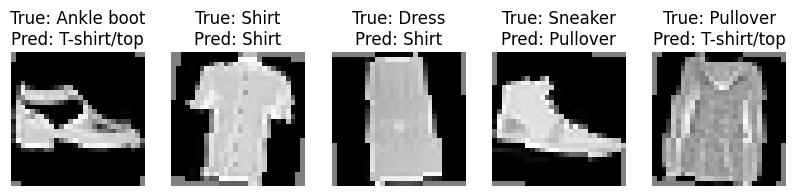

In [13]:
# Function to visualize some of the misclassified images
def visualize_misclassified_images(misclassified_images, true_labels, predicted_labels, class_names, num_images=5, name=""):
    print(f"Misclassified images ({name})")
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(misclassified_images))):
        image = misclassified_images[i].cpu().numpy().squeeze()
        true_label = class_names[true_labels[i].cpu().item()]
        predicted_label = class_names[predicted_labels[i].cpu().item()]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    plt.show()

# Define class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize some of the misclassified images
visualize_misclassified_images(misclassified_images_val, true_labels_val, predicted_labels_val, class_names, num_images=5, name="Validation")
visualize_misclassified_images(misclassified_images_test, true_labels_test, predicted_labels_val, class_names, num_images=5, name="Test")

In [14]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Function to extract embeddings
def extract_embeddings(model, image_train_loader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for image_data, image_labels in tqdm((image_train_loader), desc=f"Extracting"):
            image_input = image_data.view(-1, 1, 28, 28).float()
            image_embedding, _ = model(image_input)
            embeddings.append(image_embedding)
            labels.append(image_labels)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Extract embeddings for training data
train_embeddings, train_labels = extract_embeddings(best_model, trainloader)

Extracting: 100%|██████████| 750/750 [00:16<00:00, 45.93it/s]


Number of components for 90% explained variance: 9


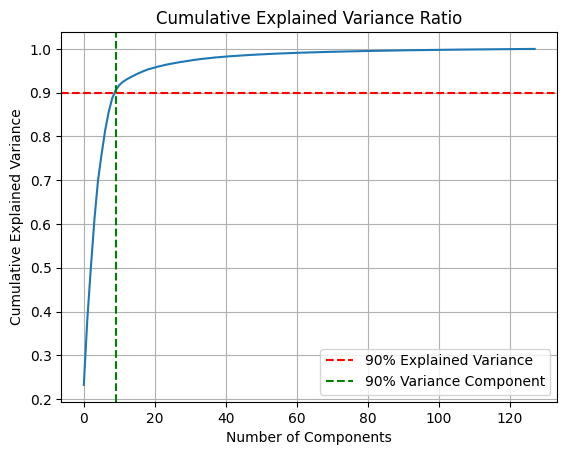

In [15]:
# Fit PCA
pca = PCA()
pca.fit(train_embeddings)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the index where cumulative explained variance ratio first surpasses 0.9
index_90_percent = np.argmax(cumulative_variance >= 0.9)
print(f"Number of components for 90% explained variance: {index_90_percent}")

# Plot cumulative explained variance ratio
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axvline(x=index_90_percent, color='g', linestyle='--', label='90% Variance Component')
plt.grid(True)
plt.legend()
# output_path = os.path.join(output_dir, 'Cumulative Explained Variance Ratio Image.png')
# plt.savefig(output_path)
plt.show()

In [16]:
# Function to apply PCA
def apply_pca(embeddings, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

# Apply PCA
num_components = 8  # You can choose any number of components
pca_embeddings = apply_pca(train_embeddings, num_components)

In [17]:
print("pca_embeddings data type:", type(pca_embeddings))
print("pca_embeddings shape:", pca_embeddings.shape)

# Check the data type and shape of labels
train_labels_np = train_labels.numpy()
print("labels data type:", type(train_labels_np))
print("labels shape:", train_labels_np.shape)

pca_embeddings data type: <class 'numpy.ndarray'>
pca_embeddings shape: (48000, 8)
labels data type: <class 'numpy.ndarray'>
labels shape: (48000,)


/Users/jaydeepradadiya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


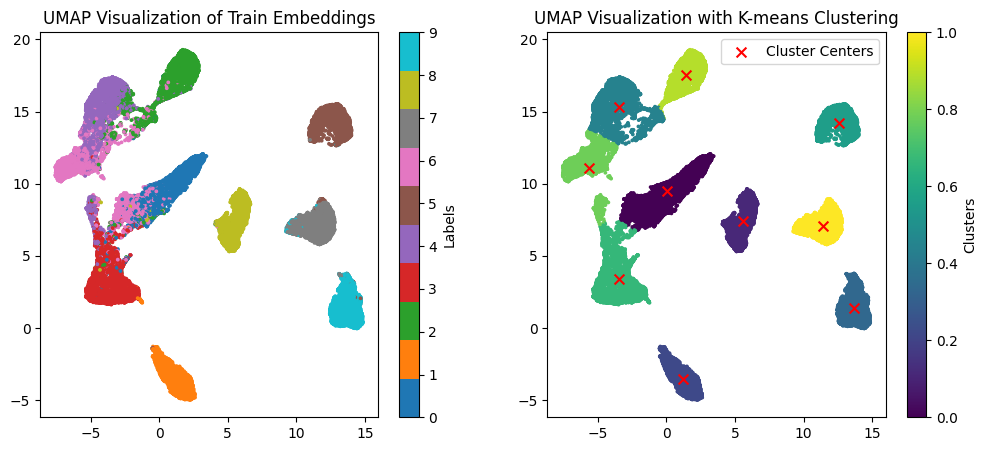

In [18]:
import umap.umap_ as umap

# Function to apply UMAP, visualize embeddings, and perform k-means clustering
def visualize_umap_with_clustering(embeddings, labels, num_clusters):
    # Apply UMAP for dimensionality reduction
    umap_result = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    
    # Plot UMAP embeddings
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='tab10', s=3)
    plt.title('UMAP Visualization of Train Embeddings')
    plt.colorbar(label='Labels')
#     output_path = os.path.join(output_dir, 'UMAP Visualization of Train Embeddings Image.png')
#     plt.savefig(output_path)
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(umap_result)
    cluster_centers = kmeans.cluster_centers_  # Get cluster centers
    
    # Plot UMAP embeddings with cluster assignments and cluster centers
    plt.subplot(1, 2, 2)
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels, cmap='viridis', s=3)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
    plt.title('UMAP Visualization with K-means Clustering')
    plt.colorbar(label='Clusters')
    plt.legend()
#     output_path = os.path.join(output_dir, 'UMAP Visualization with K-means Clustering Image.png')
#     plt.savefig(output_path)
    plt.show()

# Assuming you have your embeddings stored in pca_embeddings and labels in train_labels_np
# Also, assuming the number of clusters is 10
visualize_umap_with_clustering(pca_embeddings, train_labels_np, num_clusters=10)